We introduce in this notebook **AIC for linear regression** and **Simulated Annealing**. But first we review some information theory and the $KL(p|q)$divergence.

The Kl-divergence measures the average addtional amout of information required to specify the value of $X$ if instead of using the true $p(x)$ we use $q(x)$ to design an encoding scheme.

$$KL(p|q) = - \int p(x)\ln(\frac{q(x)}{p(x)})dx $$

Using Jensen's inequality we can prove that $KL(p|q) \geq 0$, with equality happens iff $p(x) = q(x)$

The relation between information theory and the problem of learning is established by asking a question:  suppose nature has a true “population” distribution p(x). As usual I am given a sample, and make my effort learning a distribution from this sample, q(x). Our question then is: how good did i do? And what additional uncertainty did I introduce by using q
instead of p ?

This is what $KL(p|q)$ can answer. It provides us a measure how far we are from the perfect accuracy by using q.

# A simple example

Consider a Bernoulli distribution with probability $p = 0.3$. The domain of this discrete distribution is $\{0,1\}$. Consider using another with parameter q to approximate it. You can see that the divergence is 0 for $q = 0.3$ and always higher for any other q.


In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)

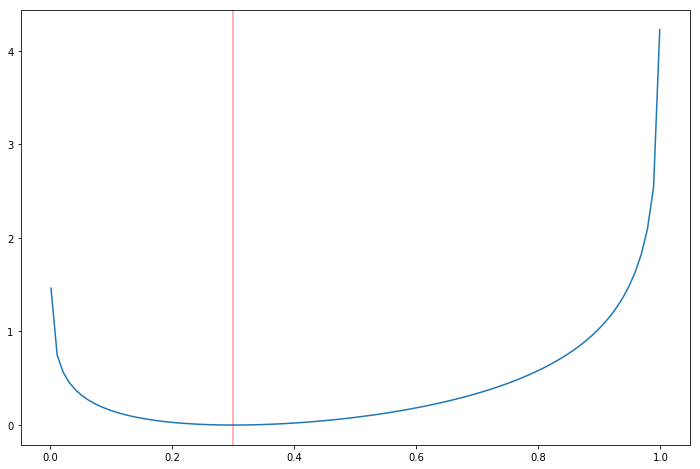

In [36]:
p = 0.3

def kld(p,q):
    return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))

qs = np.linspace(0.001,0.999,100)
plt.plot(qs, [kld(0.3, q) for q in qs])
plt.axvline(0.3, 0, 4, color='r', alpha=0.4)

# Maximum likelihood justification

We will use $KL(p|q)$ to justify Maximum likelihood estimation. Indeed, minimizing $KL(p|q)$ is equivalent to maximize the likelihood of data. 

Suppose our data is generated from an unknown distribution $p(x)$ that we wish to model. We can try to approximate this distribution with $q(x|\theta)$, controlled by ajustable parameters $\theta$, for example a Gaussian distribution. We can determine $\theta$ by minizing the KL divergence between $p(x)$ and $q(x|\theta)$ with respect to $\theta$.

We cannot minimize KL divergence directly since we do not know $p(x)$. Again, sampling come to rescue. Suppose that we have a finite set of training points $x_n$, for $n = 1 \ldots N$, drawn from $p(x)$ the using the law of large number we can approximate KL since $KL(p|q) = -E_{p}[\ln(\frac{q(x)}{p(x)})]$, so that $$KL(p|q) \approx \frac{1}{N}\sum_{n=1}^{N}(-ln(q(x_n|\theta)) + \ln(p(x_n)))$$

The scecond term is indepedent of $\theta$. The first term is the negative log likelihood function for $\theta$ under the distribution $q(x|\theta)$ evaluated using the training set. Thus we see that minimizing the KL divergence is equivalent to maximizing the likelihood function.

# From Divergence to Deviance

Suppose we have to models $q$ and $r$. We want to compare them by computing the difference between their respective KL-divergence compared to the true probability distribution $p$: $$KL(p|q) - KL(p|r)$$. Empirically, we can evaluate this $$KL(p|q) - KL(p|r) = \frac{1}{N}\sum_i\log(\frac{r_i}{q_i}) = \frac{1}{N}\log(\frac{L_r}{L_q})$$

This ratio inside the brackets on the right is the likelihood ratio and is used to test the goodness of fit.

If we define deviance $$D(q) = -2\sum_i\log(q)$$ then we have $$KL(p|q) - KL(p|r) = \frac{1}{2N}(D(q) - D(r))$$

A good-fit model should have small deviance.

The end game of any learning procedure is generalization. In the context of deviance measure, we want to estimate the out-of-sample deviance of a learning algorithm. This is done by computing the **Akake Information Criterion**: $AIC = D_{train} + 2p$, where p is the number of parameters.

# The baseball dataset

    We will analyze the following dataset https://ww2.amstat.org/publications/jse/v6n2/datasets.watnik.html

    Source: Baseball data from M.R. Watnik (1998), "Pay for Play: Are
    Baseball Salaries Based on Performance", Journal of Statistics
    Education, Volume 6, number 2
    (http://www.amstat.org/publications/jse/v6n2/datasets.watnik.html)

    Description: Salaries in 1992 and 27 performance statistics for 337 baseball
    players (no pitchers) in 1991.


    salary ($1000s)
    average = batting average
    obp = on base percentage
    runs = runs scored
    hits
    doubles
    triples
    homeruns
    rbis = runs batted in
    walks
    sos = strike outs
    sbs = stolen bases
    errors
    freeagent (or eligible for free agency)
    arbitration (or eligible for arbitration)
    runsperso = runs/sos
    hitsperso = hits/sos
    hrsperso = homeruns/sos
    rbisperso = rbis/sos
    walksperso = walks/sos
    obppererror = obp/errors
    runspererror = runs/errors
    hitspererror = hits/errors
    hrspererror = homeruns/errors
    soserrors = sos*errors
    sbsobp = sbs*obp
    sbsruns = sbs*runs
    sbshits = sbs*hits

We want to predict the player salaries from various statistics about the player. Specifically, we want to select an optimal set of features that would give us a good salary prediction. We  want to be parsimonious about these features so that we don't overfit.

In [18]:
import pandas as pd

In [37]:
baseball = pd.read_table('../data/baseball.dat', sep='\s+')
baseball.head()

,salary,average,obp,runs,hits,doubles,triples,homeruns,rbis,walks,...,rbisperso,walksperso,obppererror,runspererror,hitspererror,hrspererror,soserrors,sbsobp,sbsruns,sbshits
0,3300,0.272,0.302,69,153,21,4,31,104,22,...,1.3000,0.2750,0.0755,17.2500,38.2500,7.7500,320,1.208,276,612
1,2600,0.269,0.335,58,111,17,2,18,66,39,...,0.9565,0.5652,0.0838,14.5000,27.7500,4.5000,276,0.000,0,0
2,2500,0.249,0.337,54,115,15,1,17,73,63,...,0.6293,0.5431,0.0562,9.0000,19.1667,2.8333,696,2.022,324,690
3,2475,0.260,0.292,59,128,22,7,12,50,23,...,0.7812,0.3594,0.0133,2.6818,5.8182,0.5455,1408,6.132,1239,2688
4,2313,0.273,0.346,87,169,28,5,8,58,70,...,1.0943,1.3208,0.0384,9.6667,18.7778,0.8889,477,1.038,261,507


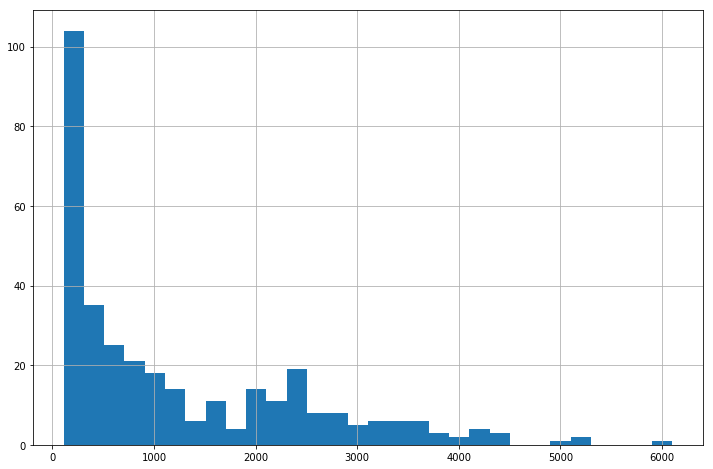

In [38]:
baseball.salary.hist(bins=30)

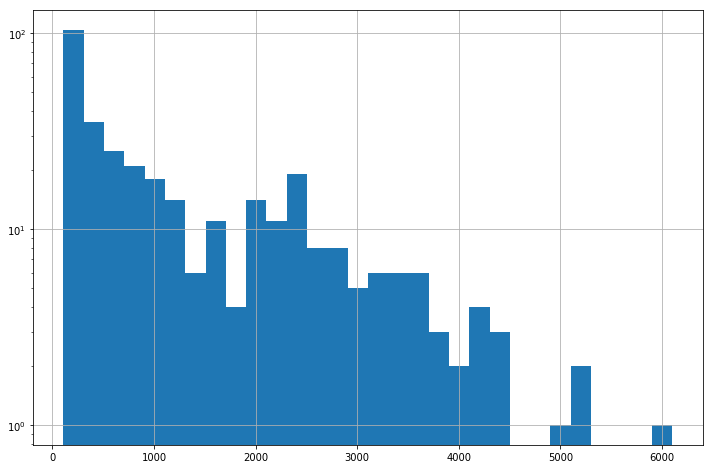

In [39]:
baseball.salary.hist(bins=30)
plt.yscale('log')

Since the salaries are highly skewed, a log transform on the salaries is a good idea

In [48]:
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

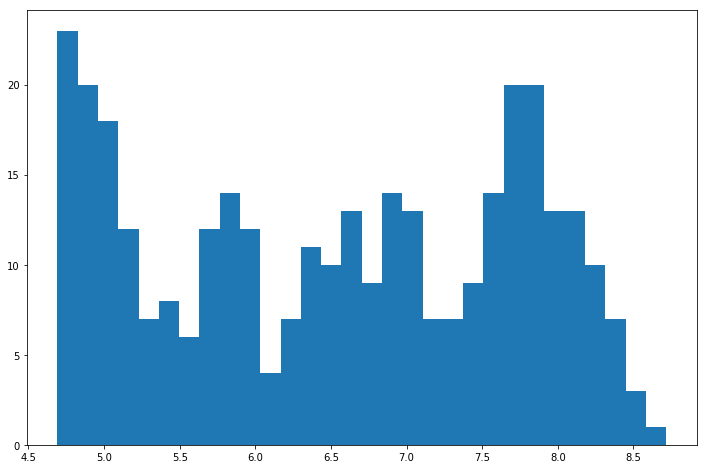

In [52]:
plt.hist(logsalary, bins=30);

# AIC for linear regression

The AIC for a model the training deviance plus twice the number of parameters. $AIC = D_{train} + 2p$ where the deeviance is defined as: $$D(q) = -2\sum_i\log(q_i)$$

Thus 

$$AIC = N\log(\frac{SSE}{N}) + 2p + constant$$

SSE is the sum of squares of the errors which follows a normal distribution.

In [55]:
from sklearn.linear_model import LinearRegression
aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

# Using AIC to search for good features

Our goal is to search for a subset of features that are good. Their goodness is measure using AIC score. If the AIC score is low then we have a good subset of features. 

We can generate all possible combination of features but this will be very expensive. For example, for the baseball model we have 27 features, there are possibly $2^27$ models! So there is no way we are goig to be able to do an exhausive search.

The basic idea is to start with some solution, and pertube it a bit to get another solution in the **local** neighborhood of the initial solution. Note that a solution here means a choosen subset of features. 

We want to start with different randomly choosen solutions, since the local search can get trapped in the local minima.

We will start with 5 different solutions as to which features to choose, and run the local search algorithm for 15 iterations., starting from each of these 5 initial solutions.

In [60]:
nstarts = 5
iterations = 15
runs = np.random.binomial(1, 0.5, ncols*nstarts).reshape((nstarts,ncols)).astype(bool)
runs

array([[False, False, False,  True, False,  True,  True,  True,  True,
        False,  True, False,  True,  True, False, False, False,  True,
        False, False, False,  True,  True,  True,  True,  True,  True],
       [ True, False, False, False,  True, False,  True, False, False,
        False,  True,  True,  True, False, False,  True,  True,  True,
         True, False, False, False,  True,  True,  True,  True, False],
       [ True,  True,  True, False, False,  True, False, False, False,
         True,  True,  True, False, False, False, False,  True,  True,
        False,  True,  True,  True, False, False, False, False,  True],
       [False, False,  True, False, False,  True, False, False,  True,
         True, False, False,  True,  True, False,  True,  True, False,
        False,  True,  True, False, False, False, False, False, False],
       [ True, False, False,  True,  True, False,  True,  True, False,
        False,  True,  True, False, False,  True, False,  True, False,
  

Here is our algorithm.
1. For each start
    - for each iteration
        - with our initial predictors we fit for the regression and calculate the aic
        - we now get the 1-change neighborhhod by:
            - systematically flipping each column and calculating the aic
            - find the minimum aic for the process and record the predictors
    - record the solution for this starting point

In [61]:
from sklearn.linear_model import LinearRegression

runs_aic = np.empty((nstarts, iterations))

for i in range(nstarts):
    
    run_current = runs[i]
    
    for j in range(iterations):
        
        # Extract current set of predictors
        run_vars = predictors[predictors.columns[run_current]]
        g = LinearRegression().fit(X=run_vars, y=logsalary)
        run_aic = aic(g, run_vars, logsalary)
        run_next = run_current
        
        # Test all models in 1-neighborhood and select lowest AIC
        for k in range(ncols):
            run_step = run_current.copy()
            run_step[k] = not run_current[k]
            run_vars = predictors[predictors.columns[run_step]]
            g = LinearRegression().fit(X=run_vars, y=logsalary)
            step_aic = aic(g, run_vars, logsalary)
            if step_aic < run_aic:
                run_next = run_step.copy()
                run_aic = step_aic
            
        run_current = run_next.copy()
        runs_aic[i,j] = run_aic
        
    runs[i] = run_current

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


(-430, -380)

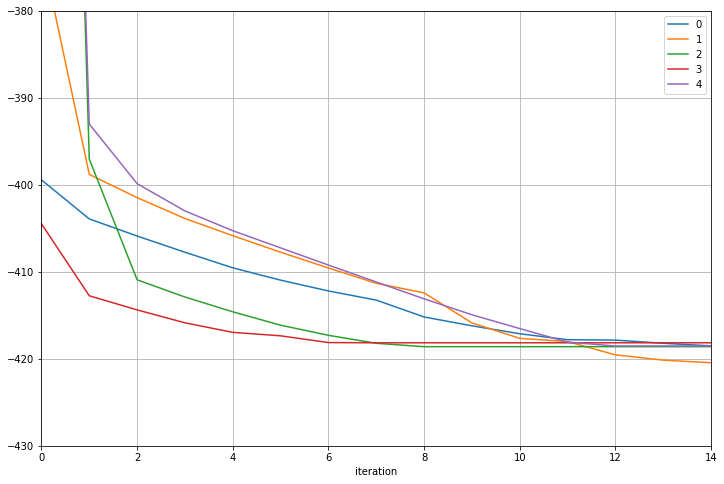

In [80]:
pd.DataFrame(runs_aic).T.plot(grid=True)
plt.xlabel('iteration')
plt.ylim([-430, -380])


In [64]:
for i in range(5):
    print(i, np.min(runs_aic[i]))

0 -418.50685611497227
1 -420.45106190483517
2 -418.6030198380479
3 -418.1566577724648
4 -418.523655509027


Note that ``runs`` store the best subset features for each random start configuration of features. Hence, to see which features are really important, see how many of the 5 solutions do they appear in…

In [66]:
pd.Series(runs.sum(0), index=predictors.columns).sort_values(ascending=False)


arbitration     5
runs            5
rbis            5
sos             5
freeagent       5
runsperso       4
sbsobp          3
hitspererror    3
obppererror     3
errors          3
hitsperso       3
sbsruns         2
triples         2
average         2
runspererror    2
soserrors       1
sbshits         1
hrsperso        0
rbisperso       0
sbs             0
walksperso      0
walks           0
homeruns        0
hrspererror     0
doubles         0
hits            0
obp             0
dtype: int64

And we can also query what the use of features in the final solutions was…


In [67]:
for i in range(nstarts):
    print(np.where(runs[i]==True))


(array([ 2,  5,  7,  9, 12, 13, 14, 19, 20, 21, 24, 25]),)
(array([ 0,  2,  7,  9, 12, 13, 14, 15, 23, 24, 25]),)
(array([ 2,  5,  7,  9, 11, 12, 13, 19, 20, 21]),)
(array([ 2,  7,  9, 11, 12, 13, 14, 15, 19, 21]),)
(array([ 0,  2,  7,  9, 11, 12, 13, 14, 15, 24, 26]),)


In [85]:
predictors.columns

Index(['average', 'obp', 'runs', 'hits', 'doubles', 'triples', 'homeruns',
       'rbis', 'walks', 'sos', 'sbs', 'errors', 'freeagent', 'arbitration',
       'runsperso', 'hitsperso', 'hrsperso', 'rbisperso', 'walksperso',
       'obppererror', 'runspererror', 'hitspererror', 'hrspererror',
       'soserrors', 'sbsobp', 'sbsruns', 'sbshits'],
      dtype='object')

In [87]:
np.where(predictors.columns=='arbitration')

(array([13]),)